In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
def load_data(file_name):
    assert(os.path.exists(file_name+'.pkl'))
    with open(file_name + '.pkl', 'rb') as f:
        data = pickle.load(f)
    return data

In [22]:
def save_data(data, file_path):
    with open(file_path + '.pkl','wb') as f:
        pickle.dump(data,f,pickle.HIGHEST_PROTOCOL)

#### The hatespeech data can be found [here](https://github.com/t-davidson/hate-speech-and-offensive-language). Features are extracted from each tweet using [fasttext](https://pypi.org/project/fasttext/). Data is preprocessed in "preprocess_text_data.py" and saved in "hatespeech_data.pkl". Refer to section 6 of the paper for a detailed description of preprocessing and human predictions modeling. In this notebook we only load the data which we previously generated using the "preprocess_text_data.py".

In [23]:
constraints = [0.2,0.4,0.6,0.8]
data_path = 'hatespeech_data'
model_dir = 'models/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

#### The CNN architecture that we used for text classification is that of [Kim 2014](https://arxiv.org/abs/1408.5882).

In [24]:
class CNN(nn.Module):
    def __init__(self, vocab_size, n_filters, filter_sizes, output_dim,
                 dropout):
        super().__init__()
        self.conv_0 = nn.Conv1d(in_channels=1,
                                out_channels=n_filters,
                                kernel_size=(filter_sizes[0]))

        self.conv_1 = nn.Conv1d(in_channels=1,
                                out_channels=n_filters,
                                kernel_size=(filter_sizes[1]))

        self.conv_2 = nn.Conv1d(in_channels=1,
                                out_channels=n_filters,
                                kernel_size=(filter_sizes[2]))

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, text):

        embedded = text.unsqueeze(1)

        conved_0 = F.relu(self.conv_0(embedded).squeeze(2))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(2))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(2))


        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)

        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))

        cat = self.fc(cat)
        cat = self.logsoftmax(cat).squeeze()
        return cat

#### The CNN architecture for the [surrogate-based triage](https://arxiv.org/abs/2006.01862)

In [25]:
class CNN_rej(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout):
        
        super().__init__()
                        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
                
        self.convs_rej = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc_rej = nn.Linear(len(filter_sizes) * n_filters, 1)
        
        self.dropout_rej = nn.Dropout(dropout)
        
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, embedded):
        
        embedded = embedded.unsqueeze(1)
        
        conved = [F.relu(conv(embedded)).squeeze(2) for conv in self.convs]
            
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        
        embedded_rej = embedded.unsqueeze(1)
                
        conved_rej = [F.relu(conv(embedded)).squeeze(2) for conv in self.convs_rej]
                            
        pooled_rej = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
                
        cat_rej = self.dropout_rej(torch.cat(pooled, dim = 1))

        out_rej = self.fc_rej(cat_rej)
        
        out = self.fc(cat)
        out =  torch.cat((out, out_rej), 1)

        out = self.softmax(out)
        return out

# Our Method : [Learning Under Triage](https://arxiv.org/abs/2103.08902)

#### According to the optimal triage policy, we need to outsource the samples for which the difference between machine loss and human loss is greater than the threshold $t_{P,b,m}$ (refer to equation 3 in the paper). This is equivalent to sorting the samples based on the difference of machine loss and human loss and then outsourcing the top b samples to human. Please refer to line 9 of Algorithm1 in the paper.

In [26]:
def find_machine_samples(machine_loss, hloss,constraint):
    
    diff = machine_loss - hloss
    argsorted_diff = torch.clone(torch.argsort(diff))
    num_outsource = int(constraint * machine_loss.shape[0])
    index = -num_outsource

    while (index < -1 and diff[argsorted_diff[index]] <= 0):
        index += 1

    machine_list = argsorted_diff[:index]

    return machine_list

#### Here we train the machine model on its points. In each iteration first, the machine points are found and then the machine model is trained on them. We use early stopping with a patience of 10 epochs based on the performance on the validation set to determine when to stop training.

In [17]:
def train_triage(data_path,constraint):
    machine_type = 'Differentiable'
    print('training machine model using constraint:',constraint,' and machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).long().to(device)
    hloss = data['hloss'].to(device)
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hloss = data['val']['hloss'].to(device)
    
    batch_size = 64
    num_batches = int(X.shape[0] / batch_size)
    
    num_epochs = 30
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    if constraint == 0.2:
        lr = 0.005
    else:
        lr = 0.0002

    optimizer = torch.optim.Adam(mnet.parameters(),lr = lr)
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    eps = 1e-4
    max_patience = 10
    patience = 0
    
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        with torch.no_grad():
            mprim = copy.deepcopy(mnet)
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            hloss_batch = hloss[i * batch_size: (i + 1) * batch_size]
            machine_scores_batch = mprim(X_batch)
            machine_loss_batch = loss_func(machine_scores_batch,Y_batch)
            machine_loss.extend(machine_loss_batch.detach())
            machine_indices = find_machine_samples(machine_loss_batch, hloss_batch, constraint)

            X_machine = X_batch[machine_indices]
            Y_machine = Y_batch[machine_indices]
            optimizer.zero_grad()
            loss = loss_func(mnet(X_machine),Y_machine)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        with torch.no_grad():
            val_loss = 0
            val_machine_scores = mprim(val_X)
            val_machine_loss = loss_func(val_machine_scores,val_Y)
            
            val_machine_indices = find_machine_samples(val_machine_loss,val_hloss,constraint)
            val_loss = float(loss_func(mnet(val_X[val_machine_indices]),val_Y[val_machine_indices]).mean())
            print('val_loss:',val_loss) 
            
            if val_loss + eps < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_Differentiable' + str(constraint))
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            val_losses.append(val_loss)
        
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break

        print('\n')
            
        if epoch%5==0:
            fig, ax = plt.subplots()
            plt.title('b = ' + str(constraint) + ' epoch : ' + str(epoch),fontsize=22)
            plt.xlim(-5.5,1.3)
            plt.ylim([-24,8])
            plt.xticks([-5,-2,1],[r'$2^{-5}$',r'$2^{-2}$',r'$2^0$'])
            plt.yticks([-20,-10,1],[r'$2^{-20}$',r'$2^{-10}$',r'$2^{0}$'])
            plt.xlabel(r'Human Loss',fontsize=22)
            plt.ylabel(r'Machine Loss',fontsize=22)
            line = np.linspace(-6.2,1.3,100)
            plt.plot(line,line,'--')
            machine_loss = torch.tensor(machine_loss, device = 'cpu')
            plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)  
            plt.show()
        
    
        
    plt.plot(range(len(train_losses)),train_losses,marker='o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker='o',label='validation')
    plt.legend()
    plt.title(machine_type + ' b = ' + str(constraint),fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()


training machine model using constraint: 0.2  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.5830629932073256
val_loss: 0.5282633900642395
updated the model




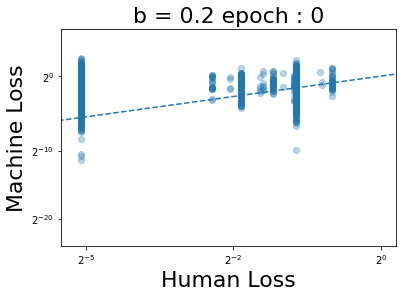

----- epoch: 1 -----
machine_loss: 0.24167689093155786
val_loss: 0.15582334995269775
updated the model


----- epoch: 2 -----
machine_loss: 0.21530284457063922
val_loss: 0.13622553646564484
updated the model


----- epoch: 3 -----
machine_loss: 0.19893610773336454
val_loss: 0.12943293154239655
updated the model


----- epoch: 4 -----
machine_loss: 0.193937427548614
val_loss: 0.12253402173519135
updated the model


----- epoch: 5 -----
machine_loss: 0.1835657176998211
val_loss: 0.11764748394489288
updated the model




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


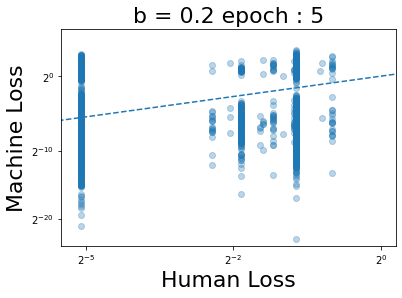

----- epoch: 6 -----
machine_loss: 0.17381575179751962
val_loss: 0.10841110348701477
updated the model


----- epoch: 7 -----
machine_loss: 0.1660476693068631
val_loss: 0.10000869631767273
updated the model


----- epoch: 8 -----
machine_loss: 0.1566915187771277
val_loss: 0.09284666925668716
updated the model


----- epoch: 9 -----
machine_loss: 0.15055952327869213
val_loss: 0.09405958652496338


----- epoch: 10 -----
machine_loss: 0.14753552485005153
val_loss: 0.08459720015525818
updated the model




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


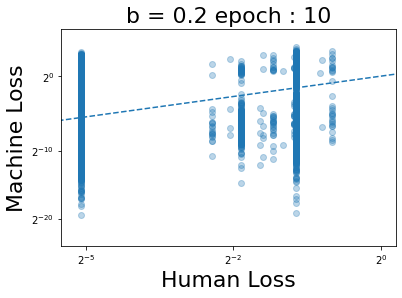

----- epoch: 11 -----
machine_loss: 0.14460899465484545
val_loss: 0.07843989878892899
updated the model


----- epoch: 12 -----
machine_loss: 0.13623605287769655
val_loss: 0.07547230273485184
updated the model


----- epoch: 13 -----
machine_loss: 0.13476926632089695
val_loss: 0.06472861021757126
updated the model


----- epoch: 14 -----
machine_loss: 0.13478199606470298
val_loss: 0.06686535477638245


----- epoch: 15 -----
machine_loss: 0.1320117384675541
val_loss: 0.06714271008968353




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


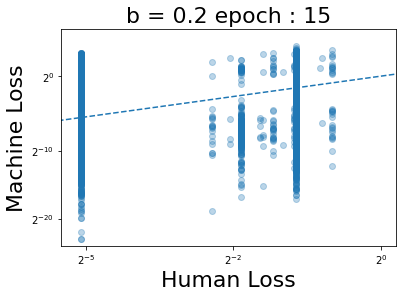

----- epoch: 16 -----
machine_loss: 0.13256662072672043
val_loss: 0.06701046228408813


----- epoch: 17 -----
machine_loss: 0.13211419710811848
val_loss: 0.06568814069032669


----- epoch: 18 -----
machine_loss: 0.12502755523261536
val_loss: 0.06674247980117798


----- epoch: 19 -----
machine_loss: 0.1252309556827337
val_loss: 0.06714756041765213


----- epoch: 20 -----
machine_loss: 0.12616179139877204
val_loss: 0.062367066740989685
updated the model




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


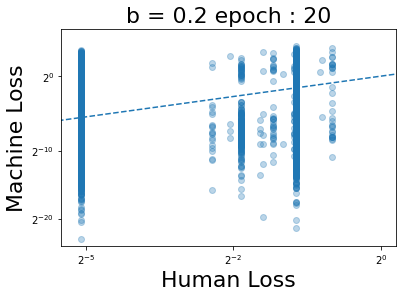

----- epoch: 21 -----
machine_loss: 0.12210888060750828
val_loss: 0.05851659178733826
updated the model


----- epoch: 22 -----
machine_loss: 0.11952914450860892
val_loss: 0.06313350796699524


----- epoch: 23 -----
machine_loss: 0.1227438992258006
val_loss: 0.061230774968862534


----- epoch: 24 -----
machine_loss: 0.12153314652581078
val_loss: 0.058294638991355896
updated the model


----- epoch: 25 -----
machine_loss: 0.11793374213205728
val_loss: 0.060412272810935974




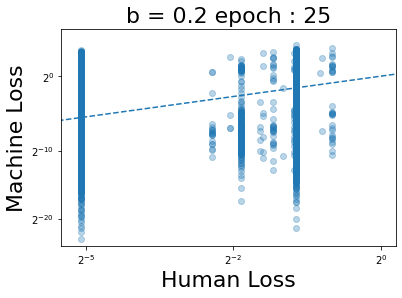

----- epoch: 26 -----
machine_loss: 0.12144178577485339
val_loss: 0.06054101511836052


----- epoch: 27 -----
machine_loss: 0.12066172650277925
val_loss: 0.0591374896466732


----- epoch: 28 -----
machine_loss: 0.12156494934849131
val_loss: 0.06227229908108711


----- epoch: 29 -----
machine_loss: 0.1149928162873645
val_loss: 0.054666612297296524
updated the model




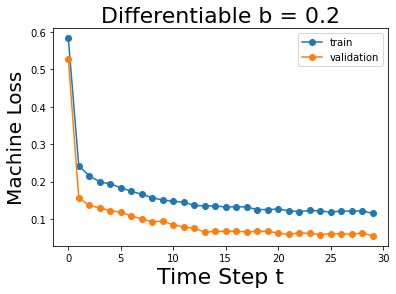

training machine model using constraint: 0.4  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.9551248122006655
val_loss: 0.9076784253120422
updated the model




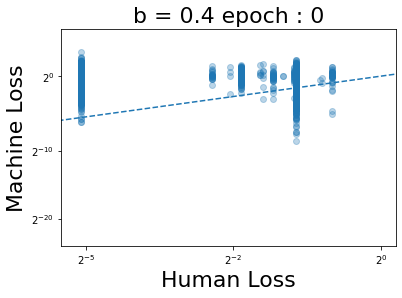

----- epoch: 1 -----
machine_loss: 0.1531803273149611
val_loss: 0.11904837191104889
updated the model


----- epoch: 2 -----
machine_loss: 0.007028546110329141
val_loss: 0.0018135644495487213
updated the model


----- epoch: 3 -----
machine_loss: 0.0015154339439504838
val_loss: 0.001000278745777905
updated the model


----- epoch: 4 -----
machine_loss: 0.0007824154410324505
val_loss: 0.0006137142772786319
updated the model


----- epoch: 5 -----
machine_loss: 0.0005318167282742555
val_loss: 0.0004314961552154273
updated the model




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


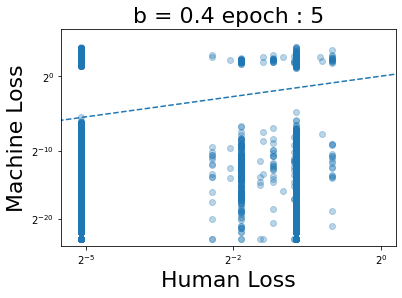

----- epoch: 6 -----
machine_loss: 0.0003763021155691604
val_loss: 0.0003049630904570222
updated the model


----- epoch: 7 -----
machine_loss: 0.0002814074819070811
val_loss: 0.0002495786175131798


----- epoch: 8 -----
machine_loss: 0.0002296117877828389
val_loss: 0.0002006967697525397
updated the model


----- epoch: 9 -----
machine_loss: 0.00018565818881673599
val_loss: 0.00016199739184230566


----- epoch: 10 -----
machine_loss: 0.00015680118195859905
val_loss: 0.00013891118578612804




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


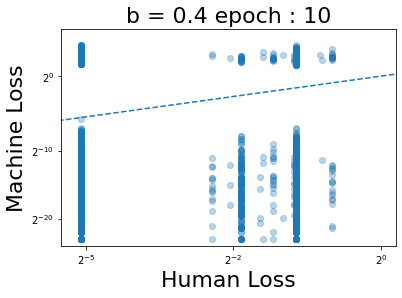

----- epoch: 11 -----
machine_loss: 0.00012778709113566342
val_loss: 0.00011013793846359476


----- epoch: 12 -----
machine_loss: 0.00011430664504056647
val_loss: 9.934949048329145e-05
updated the model


----- epoch: 13 -----
machine_loss: 9.841601700107579e-05
val_loss: 9.132071863859892e-05


----- epoch: 14 -----
machine_loss: 8.708821411100114e-05
val_loss: 7.457564788637683e-05


----- epoch: 15 -----
machine_loss: 7.294944204261355e-05
val_loss: 6.317054067039862e-05




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


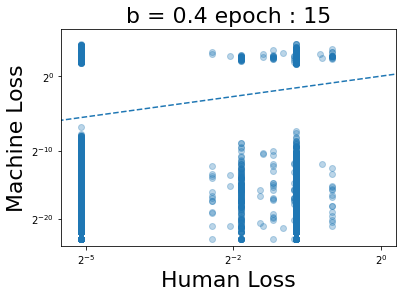

----- epoch: 16 -----
machine_loss: 6.706643465292927e-05
val_loss: 5.677798617398366e-05


----- epoch: 17 -----
machine_loss: 5.672166498034888e-05
val_loss: 5.399732617661357e-05


----- epoch: 18 -----
machine_loss: 4.9376144393894115e-05
val_loss: 4.7428224206669256e-05


----- epoch: 19 -----
machine_loss: 4.416617779649338e-05
val_loss: 4.3253581679891795e-05


----- epoch: 20 -----
machine_loss: 4.029349672644381e-05
val_loss: 3.731616379809566e-05




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


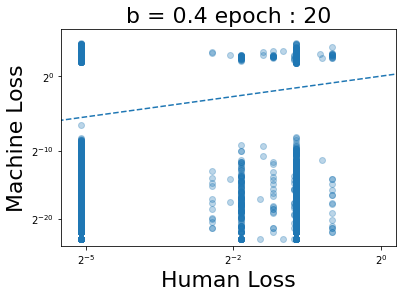

----- epoch: 21 -----
machine_loss: 3.539636081484332e-05
val_loss: 3.451560405665077e-05


----- epoch: 22 -----
machine_loss: 3.312978984363705e-05
val_loss: 2.870825665013399e-05


----- epoch: 23 -----
machine_loss: 2.8963607893691307e-05
val_loss: 2.6040126613224857e-05
no progress for 10 epochs... stopping training


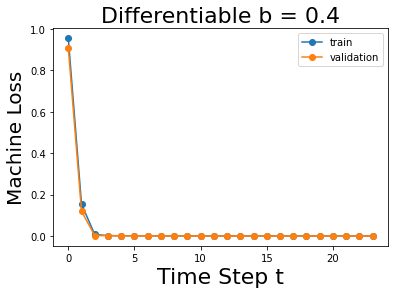

training machine model using constraint: 0.6  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.9543757134427627
val_loss: 0.9624882340431213
updated the model




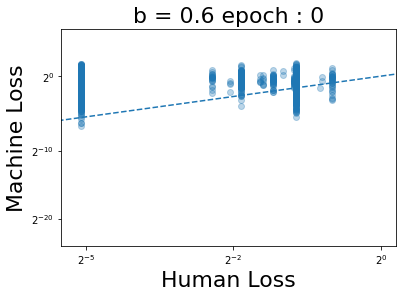

----- epoch: 1 -----
machine_loss: 0.17368379344892068
val_loss: 0.15784156322479248
updated the model


----- epoch: 2 -----
machine_loss: 0.013055341753594499
val_loss: 0.006878528278321028
updated the model


----- epoch: 3 -----
machine_loss: 0.001889973954045369
val_loss: 0.0009726106654852629
updated the model


----- epoch: 4 -----
machine_loss: 0.0007912602448717129
val_loss: 0.0005855981144122779
updated the model


----- epoch: 5 -----
machine_loss: 0.00047966220411884325
val_loss: 0.0003741729015018791
updated the model




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


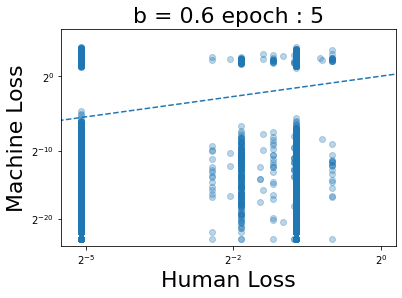

----- epoch: 6 -----
machine_loss: 0.000335373852143069
val_loss: 0.00027901033172383904


----- epoch: 7 -----
machine_loss: 0.00026130102781962705
val_loss: 0.00022075419838074595
updated the model


----- epoch: 8 -----
machine_loss: 0.0002024037723344918
val_loss: 0.0001683363225311041


----- epoch: 9 -----
machine_loss: 0.00016342079804113988
val_loss: 0.00014667658251710236


----- epoch: 10 -----
machine_loss: 0.00013221366995708195
val_loss: 0.00010718058911152184
updated the model




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


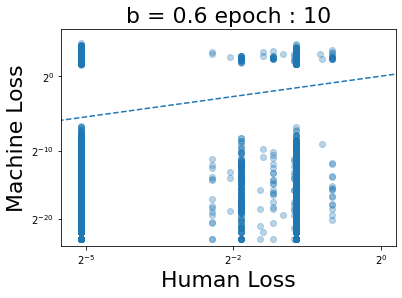

----- epoch: 11 -----
machine_loss: 0.0001111786970019087
val_loss: 9.687431884231046e-05


----- epoch: 12 -----
machine_loss: 9.689052805583742e-05
val_loss: 8.234765846282244e-05


----- epoch: 13 -----
machine_loss: 8.135180551012884e-05
val_loss: 6.974497227929533e-05


----- epoch: 14 -----
machine_loss: 7.101942897710008e-05
val_loss: 6.236047920538113e-05


----- epoch: 15 -----
machine_loss: 6.133058174384587e-05
val_loss: 5.385301119531505e-05




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


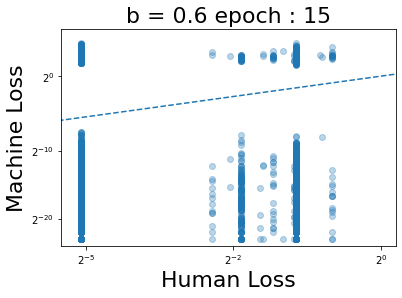

----- epoch: 16 -----
machine_loss: 5.2416259488078744e-05
val_loss: 5.137710468261503e-05


----- epoch: 17 -----
machine_loss: 4.9213580202452554e-05
val_loss: 4.255671956343576e-05


----- epoch: 18 -----
machine_loss: 4.543636916546726e-05
val_loss: 4.013353100162931e-05


----- epoch: 19 -----
machine_loss: 3.869488705987578e-05
val_loss: 3.4983062505489215e-05


----- epoch: 20 -----
machine_loss: 3.287392681746345e-05
val_loss: 2.897857120842673e-05




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


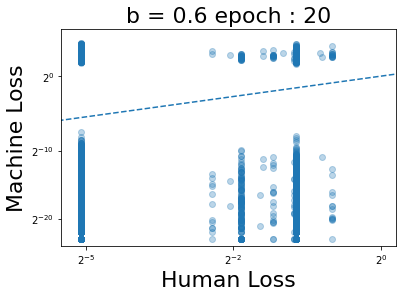

----- epoch: 21 -----
machine_loss: 3.068308631763254e-05
val_loss: 2.767183650576044e-05
no progress for 10 epochs... stopping training


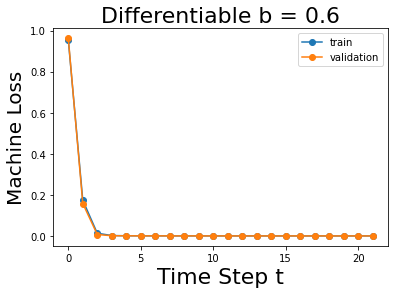

training machine model using constraint: 0.8  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 1.2641950274507205
val_loss: 1.2581627368927002
updated the model




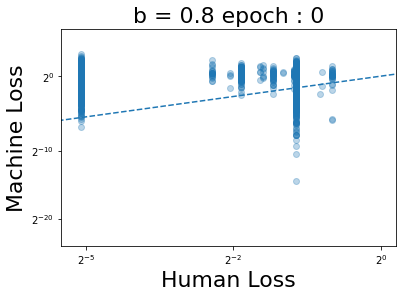

----- epoch: 1 -----
machine_loss: 0.6907951579972481
val_loss: 0.6750122904777527
updated the model


----- epoch: 2 -----
machine_loss: 0.044200053393675866
val_loss: 0.008403029292821884
updated the model


----- epoch: 3 -----
machine_loss: 0.0024669701479069772
val_loss: 0.0009297168580815196
updated the model


----- epoch: 4 -----
machine_loss: 0.0008676187017044867
val_loss: 0.0005865297862328589
updated the model


----- epoch: 5 -----
machine_loss: 0.000491535953036267
val_loss: 0.00039052244392223656
updated the model




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


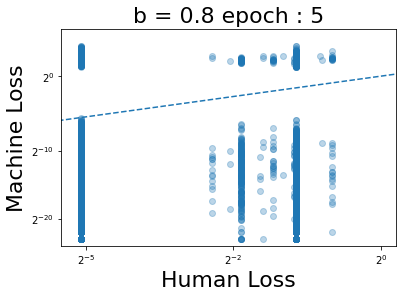

----- epoch: 6 -----
machine_loss: 0.0003256151058697772
val_loss: 0.0002954252704512328


----- epoch: 7 -----
machine_loss: 0.0002531007266384222
val_loss: 0.00020156381651759148
updated the model


----- epoch: 8 -----
machine_loss: 0.0001913005006978589
val_loss: 0.0001752143434714526


----- epoch: 9 -----
machine_loss: 0.00015568264093227904
val_loss: 0.00013687177852261811


----- epoch: 10 -----
machine_loss: 0.0001344805467150915
val_loss: 0.00011180182627867907




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


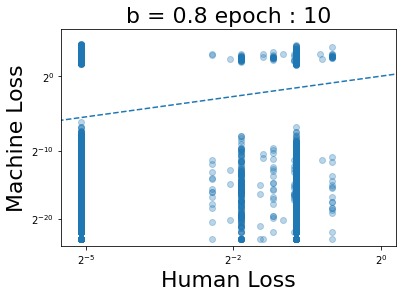

----- epoch: 11 -----
machine_loss: 0.00010116655062120117
val_loss: 9.653376037022099e-05
updated the model


----- epoch: 12 -----
machine_loss: 9.297956626141968e-05
val_loss: 8.027037983993068e-05


----- epoch: 13 -----
machine_loss: 7.428368409042226e-05
val_loss: 7.115279731806368e-05


----- epoch: 14 -----
machine_loss: 6.777982441974473e-05
val_loss: 5.879769378225319e-05


----- epoch: 15 -----
machine_loss: 5.8682381241699964e-05
val_loss: 5.269279427011497e-05




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


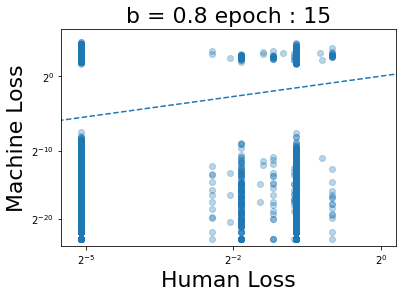

----- epoch: 16 -----
machine_loss: 4.99673508708535e-05
val_loss: 4.374521813588217e-05


----- epoch: 17 -----
machine_loss: 4.248117382843475e-05
val_loss: 3.957684020861052e-05


----- epoch: 18 -----
machine_loss: 4.014425455996692e-05
val_loss: 3.754645513254218e-05


----- epoch: 19 -----
machine_loss: 3.550111259424208e-05
val_loss: 3.401024150662124e-05


----- epoch: 20 -----
machine_loss: 3.175918846546703e-05
val_loss: 2.721056625887286e-05




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log2


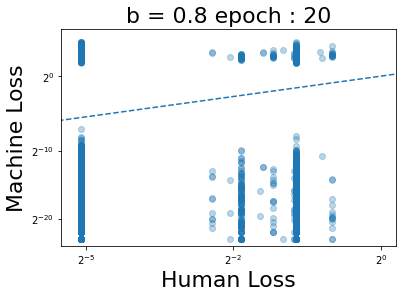

----- epoch: 21 -----
machine_loss: 2.7832712638324136e-05
val_loss: 2.4406175725744106e-05


----- epoch: 22 -----
machine_loss: 2.4494798275043195e-05
val_loss: 2.3278842490981333e-05
no progress for 10 epochs... stopping training


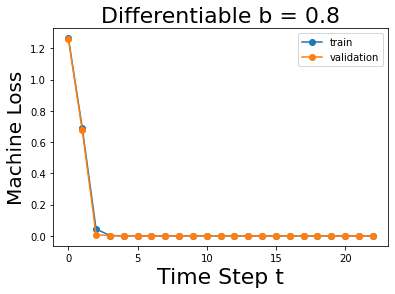

In [263]:
for constraint in constraints:
    train_triage(data_path,constraint)

#### We train the additional model g to approximate difference of machine loss and human loss for unseen samples. The same CNN and the same training procedure is used for training g. Please refer to 

In [10]:
def train_g(data_path, machine_type,constraint):
    print('started training g using the constraint: ',constraint,' Using machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(copy.deepcopy(data['X'])).float().to(device)
    Y = torch.from_numpy(copy.deepcopy(data['Y'])).long().to(device)
    hloss = data['hloss'].to(device)
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)
    
    if machine_type == 'full':
        mnet.load_state_dict(torch.load(model_dir + 'm_full'))
        
    else:
        mnet.load_state_dict(torch.load(model_dir + 'm_Differentiable' + str(constraint)))
        
    mnet.eval()
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hloss = data['val']['hloss'].to(device)
    
    batch_size = 64
    num_batches = int(X.shape[0] / batch_size)
    
    num_epochs = 50
    
    gnet = CNN(vocab_size=X.shape[1], n_filters=400, filter_sizes=[3,4,5],
               output_dim=2, dropout=0.5).to(device)
    
    g_optimizer = torch.optim.Adam(gnet.parameters(),lr=0.002)
    loss_func = torch.nn.NLLLoss(reduction='none')
    

    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        g_train_loss = 0
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            hloss_batch = hloss[i * batch_size: (i + 1) * batch_size]
            machine_loss_batch = loss_func(mnet(X_batch),Y_batch)
            machine_indices = find_machine_samples(machine_loss_batch, hloss_batch, constraint)
            g_labels = torch.tensor([0 if j in machine_indices else 1 for j in range(hloss_batch.shape[0])]).to(device)
            g_optimizer.zero_grad()
            g_loss = loss_func(gnet(X_batch),g_labels)
            g_loss.sum().backward()
            g_optimizer.step()
            g_train_loss += float(g_loss.mean())
        train_losses.append(g_train_loss/num_batches)
        print('g_loss:',g_train_loss/num_batches) 
        
        with torch.no_grad():
            val_machine_loss = loss_func(mnet(val_X),val_Y)
            val_machine_indices = find_machine_samples(val_machine_loss,val_hloss,constraint)
            val_glabels = torch.tensor([0 if j in val_machine_indices else 1 for j in range(val_X.shape[0])]).to(device)
            val_loss = loss_func(gnet(val_X),val_glabels)
            val_gloss = float(val_loss.mean())
            val_losses.append(val_gloss)
            print('val_g_loss:',float(val_gloss))
            
            if val_gloss + eps < best_val_loss:
                torch.save(gnet.state_dict(), model_dir + 'g_' + machine_type + str(constraint))
                best_val_loss = val_gloss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break

                
        print('\n')
        
    plt.plot(range(len(train_losses)),train_losses,marker = 'o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker = 'o',label='validation')
    plt.title('train and validation curve of g using b = ' + str(constraint),fontsize=22)
    plt.xlabel('Epoch',fontsize=22)
    plt.ylabel(r'g Loss',fontsize=20)
    plt.legend()
    plt.show()
        

started training g using the constraint:  0.2  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.5675421982693175
val_g_loss: 0.5204171538352966
updated the model


----- epoch: 1 -----
g_loss: 0.5178618637534479
val_g_loss: 0.5376556515693665


----- epoch: 2 -----
g_loss: 0.5140889210936924
val_g_loss: 0.5089370608329773
updated the model


----- epoch: 3 -----
g_loss: 0.5195951492836078
val_g_loss: 0.4998355805873871
updated the model


----- epoch: 4 -----
g_loss: 0.5080184545367956
val_g_loss: 0.5134015679359436


----- epoch: 5 -----
g_loss: 0.49736984353512526
val_g_loss: 0.4982089698314667
updated the model


----- epoch: 6 -----
g_loss: 0.48241607286036015
val_g_loss: 0.4838287830352783
updated the model


----- epoch: 7 -----
g_loss: 0.4860848671135803
val_g_loss: 0.4796178340911865
updated the model


----- epoch: 8 -----
g_loss: 0.48160629828150076
val_g_loss: 0.49243858456611633


----- epoch: 9 -----
g_loss: 0.47563304053619504
val_g_loss: 0.491137802600

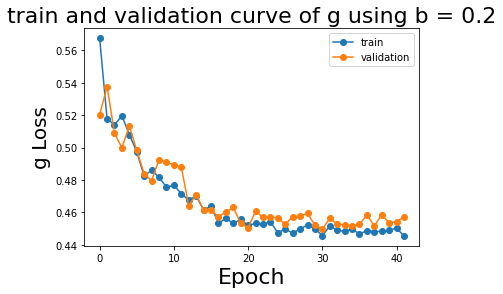

started training g using the constraint:  0.4  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.640231853350997
val_g_loss: 0.5305370092391968
updated the model


----- epoch: 1 -----
g_loss: 0.5825001304037869
val_g_loss: 0.49434030055999756
updated the model


----- epoch: 2 -----
g_loss: 0.55598405484731
val_g_loss: 0.4999753534793854


----- epoch: 3 -----
g_loss: 0.5426506982184947
val_g_loss: 0.4896216094493866
updated the model


----- epoch: 4 -----
g_loss: 0.5297507809785506
val_g_loss: 0.47881412506103516
updated the model


----- epoch: 5 -----
g_loss: 0.5204631965607405
val_g_loss: 0.46784961223602295
updated the model


----- epoch: 6 -----
g_loss: 0.510422557592392
val_g_loss: 0.46298524737358093
updated the model


----- epoch: 7 -----
g_loss: 0.5029768734239042
val_g_loss: 0.46792787313461304


----- epoch: 8 -----
g_loss: 0.5043740021064878
val_g_loss: 0.4711039364337921


----- epoch: 9 -----
g_loss: 0.4884319288345675
val_g_loss: 0.4839709401130676

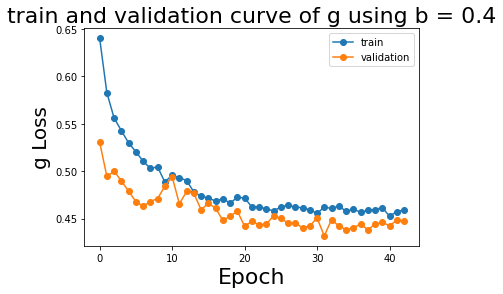

started training g using the constraint:  0.6  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.6723873084411025
val_g_loss: 0.5054290890693665
updated the model


----- epoch: 1 -----
g_loss: 0.5678100804798305
val_g_loss: 0.5074644684791565


----- epoch: 2 -----
g_loss: 0.550756533164531
val_g_loss: 0.5046491026878357
updated the model


----- epoch: 3 -----
g_loss: 0.5388810198443631
val_g_loss: 0.4806728661060333
updated the model


----- epoch: 4 -----
g_loss: 0.5283540277741849
val_g_loss: 0.4932558536529541


----- epoch: 5 -----
g_loss: 0.5181947535214325
val_g_loss: 0.4785292148590088
updated the model


----- epoch: 6 -----
g_loss: 0.5096312452418109
val_g_loss: 0.4709884822368622
updated the model


----- epoch: 7 -----
g_loss: 0.4998286950091521
val_g_loss: 0.4794222116470337


----- epoch: 8 -----
g_loss: 0.5050416286103427
val_g_loss: 0.4681837558746338
updated the model


----- epoch: 9 -----
g_loss: 0.4959567105397582
val_g_loss: 0.4671701192855835
u

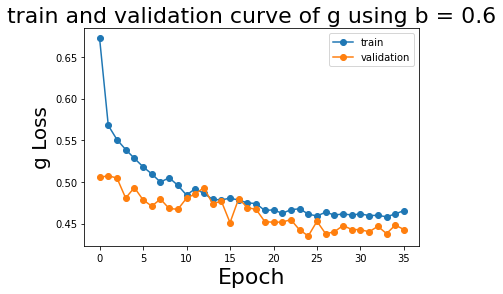

started training g using the constraint:  0.8  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.6709550308684508
val_g_loss: 0.5173126459121704
updated the model


----- epoch: 1 -----
g_loss: 0.5621709522480766
val_g_loss: 0.5135061144828796
updated the model


----- epoch: 2 -----
g_loss: 0.5513575752265751
val_g_loss: 0.4879474341869354
updated the model


----- epoch: 3 -----
g_loss: 0.5394890710401038
val_g_loss: 0.49334508180618286


----- epoch: 4 -----
g_loss: 0.5370916863903403
val_g_loss: 0.47010767459869385
updated the model


----- epoch: 5 -----
g_loss: 0.5173342721536756
val_g_loss: 0.4693191349506378
updated the model


----- epoch: 6 -----
g_loss: 0.5102823631217083
val_g_loss: 0.4714553952217102


----- epoch: 7 -----
g_loss: 0.5107036625655988
val_g_loss: 0.47565820813179016


----- epoch: 8 -----
g_loss: 0.4987731408327818
val_g_loss: 0.4593709409236908
updated the model


----- epoch: 9 -----
g_loss: 0.4949219369639953
val_g_loss: 0.51610743999481

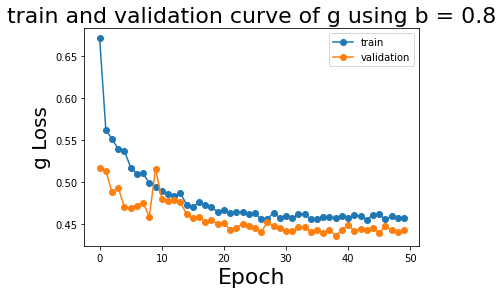

In [11]:
for constraint in constraints:
    train_g(data_path,'Differentiable',constraint)

In [253]:
def get_test_assignments_us(data_path,constraints):
    machine_type = 'Differentiable'
    loss_func = torch.nn.NLLLoss(reduction='none')
    data = load_data(data_path)
    test_X = torch.from_numpy(data['test']['X']).float().to(device)
    test_Y = data['test']['Y']
    hlabel = data['test']['hpred']
    
    losses = []
    for constraint in constraints:
        loss = np.zeros(test_X.shape[0])
        num_machine = int((1.0 - constraint) * test_X.shape[0])
        mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

        mnet.load_state_dict(torch.load(model_dir + 'm_Differentiable' + str(constraint)))
        mnet.eval()
        
        mlabel = torch.argmax(mnet(test_X),dim=1).cpu().data.numpy()
        
        gnet = CNN(vocab_size=test_X.shape[1], n_filters=400, filter_sizes=[3,4,5],
               output_dim=2, dropout=0.5).to(device)

        gnet.load_state_dict(torch.load(model_dir + 'g_Differentiable' + str(constraint)))
        gnet.eval()
        
        gprediction = torch.exp(gnet(test_X).detach()[:,1])
        to_machine = torch.argsort(gprediction)[:num_machine].cpu().data.numpy()
        to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])
        
        mloss = np.not_equal(mlabel,test_Y)
        hloss = np.not_equal(hlabel,test_Y)
        
        loss[to_machine] = mloss[to_machine]
        loss[to_human] = hloss[to_human]

        losses.append(np.mean(loss))
        del mnet
        del gnet
    
    plt.plot(constraints,losses,marker='o')
    plt.xticks(constraints)
    plt.title(r'our method',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.show()
    
    if machine_type not in data.keys():
        data[machine_type] = {}
    
    data[machine_type]['agg_loss'] = losses
    save_data(data,data_path)

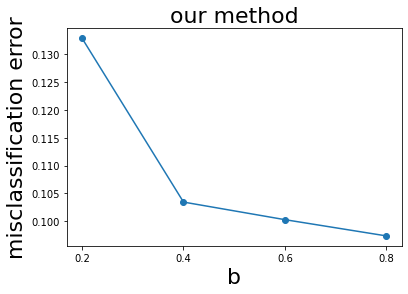

In [254]:
get_test_assignments_us(data_path,constraints)

# Baselines

## [Confidence Based Triage](https://arxiv.org/abs/2004.13102)

In [264]:
def train_confidence(data_path,constraint):
    machine_type = 'confidence'
    print('-----training machine model using constraint:',constraint,' and machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).long().to(device)
    hconf = torch.mean(data['hprob']) + torch.zeros(X.shape[0]).to(device)
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hconf = torch.mean(data['hprob']) + torch.zeros(val_X.shape[0]).to(device)
    
    batch_size = 64
    num_batches = int(X.shape[0] / batch_size)
    
    num_epochs = 30
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)
    
    if constraint == 0.2:
        lr = 0.05
    if constraint == 0.4:
        lr = 0.0003
    else:
        lr = 0.0001
        
    optimizer = torch.optim.Adam(mnet.parameters(),lr = lr)
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        with torch.no_grad():
            mprim = copy.deepcopy(mnet)
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            hconf_batch = hconf[i * batch_size: (i + 1) * batch_size]
            machine_scores_batch = mprim(X_batch)
            machine_conf_batch, _ = torch.max(machine_scores_batch,axis = 1)   
            machine_indices = find_machine_samples(hconf_batch,machine_conf_batch,constraint)
                
            X_machine = X_batch[machine_indices]
            Y_machine = Y_batch[machine_indices]
            optimizer.zero_grad()
            loss = loss_func(mnet(X_machine),Y_machine)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        with torch.no_grad():
            val_loss = 0
            val_machine_scores = mprim(val_X)
            val_machine_conf,_ = torch.max(val_machine_scores,axis=1)

            val_machine_indices = find_machine_samples(val_hconf,val_machine_conf,constraint)

            val_loss = float(loss_func(mnet(val_X[val_machine_indices]),val_Y[val_machine_indices]).mean())
            
            val_losses.append(val_loss)
            print('val_loss:',val_loss) 
            
            if val_loss + eps <best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_' + machine_type + str(constraint))
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
                
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break
      
        print('\n')
            
    plt.plot(range(len(train_losses)),train_losses,marker='o',label = 'train')
    plt.plot(range(len(val_losses)),val_losses,marker='o',label = 'validation')
    plt.legend()
    plt.title(machine_type + ' b = ' + str(constraint),fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()
        

-----training machine model using constraint: 0.2  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.8152608658807973
val_loss: 0.7854548692703247
updated the model


----- epoch: 1 -----
machine_loss: 0.7486927243880928
val_loss: 0.7177776098251343
updated the model


----- epoch: 2 -----
machine_loss: 0.6877471267556151
val_loss: 0.7038689851760864
updated the model


----- epoch: 3 -----
machine_loss: 0.6695914121034244
val_loss: 0.6530187129974365
updated the model


----- epoch: 4 -----
machine_loss: 0.6386166349984705
val_loss: 0.6365359425544739
updated the model


----- epoch: 5 -----
machine_loss: 0.6109891352243721
val_loss: 0.60967618227005
updated the model


----- epoch: 6 -----
machine_loss: 0.6112342807464302
val_loss: 0.6030378341674805
updated the model


----- epoch: 7 -----
machine_loss: 0.5840764519913743
val_loss: 0.6021533012390137
updated the model


----- epoch: 8 -----
machine_loss: 0.5870790223901471
val_loss: 0.5823045969009399
updated the m

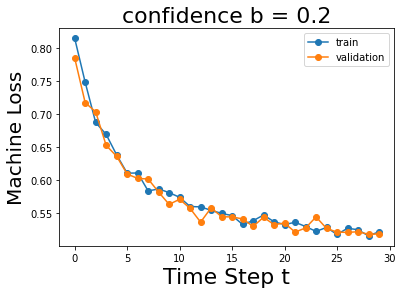

-----training machine model using constraint: 0.4  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.8355293750452498
val_loss: 0.78667151927948
updated the model


----- epoch: 1 -----
machine_loss: 0.6775507593216995
val_loss: 0.6679383516311646
updated the model


----- epoch: 2 -----
machine_loss: 0.6146115042890111
val_loss: 0.609488308429718
updated the model


----- epoch: 3 -----
machine_loss: 0.579058037760357
val_loss: 0.5594674944877625
updated the model


----- epoch: 4 -----
machine_loss: 0.542114369571209
val_loss: 0.5532649755477905
updated the model


----- epoch: 5 -----
machine_loss: 0.5368894059599066
val_loss: 0.5158904790878296
updated the model


----- epoch: 6 -----
machine_loss: 0.5258388687701275
val_loss: 0.5169883966445923


----- epoch: 7 -----
machine_loss: 0.5157649189544221
val_loss: 0.49702444672584534
updated the model


----- epoch: 8 -----
machine_loss: 0.5167045459772149
val_loss: 0.48034870624542236
updated the model


----- epoch:

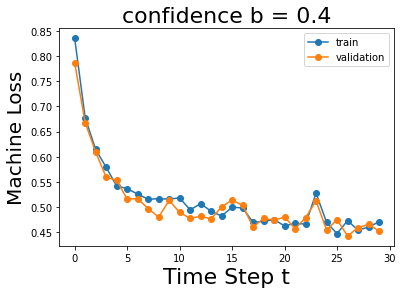

-----training machine model using constraint: 0.6  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.8800972752893964
val_loss: 0.8439935445785522
updated the model


----- epoch: 1 -----
machine_loss: 0.7824305430985987
val_loss: 0.7847591042518616
updated the model


----- epoch: 2 -----
machine_loss: 0.7394762549859782
val_loss: 0.7241630554199219
updated the model


----- epoch: 3 -----
machine_loss: 0.6818158567572633
val_loss: 0.6890812516212463
updated the model


----- epoch: 4 -----
machine_loss: 0.6597204334878674
val_loss: 0.6520661115646362
updated the model


----- epoch: 5 -----
machine_loss: 0.6169498511590064
val_loss: 0.6550203561782837


----- epoch: 6 -----
machine_loss: 0.6173403365537524
val_loss: 0.6024789810180664
updated the model


----- epoch: 7 -----
machine_loss: 0.572798625798896
val_loss: 0.5742406249046326
updated the model


----- epoch: 8 -----
machine_loss: 0.5729694606270641
val_loss: 0.5911290645599365


----- epoch: 9 -----
machine

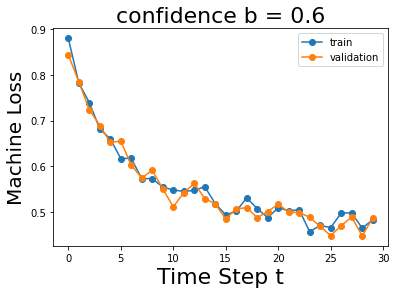

-----training machine model using constraint: 0.8  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.9141029271607598
val_loss: 0.8670920729637146
updated the model


----- epoch: 1 -----
machine_loss: 0.8205424856084088
val_loss: 0.810614824295044
updated the model


----- epoch: 2 -----
machine_loss: 0.7304302452442547
val_loss: 0.7637317776679993
updated the model


----- epoch: 3 -----
machine_loss: 0.7246820604583869
val_loss: 0.6879647374153137
updated the model


----- epoch: 4 -----
machine_loss: 0.6611489974117527
val_loss: 0.7046113014221191


----- epoch: 5 -----
machine_loss: 0.6372618017097315
val_loss: 0.609467089176178
updated the model


----- epoch: 6 -----
machine_loss: 0.6130531642896434
val_loss: 0.6035338640213013
updated the model


----- epoch: 7 -----
machine_loss: 0.6001896070471654
val_loss: 0.5913687944412231
updated the model


----- epoch: 8 -----
machine_loss: 0.5729004767878602
val_loss: 0.5621176958084106
updated the model


----- epoch

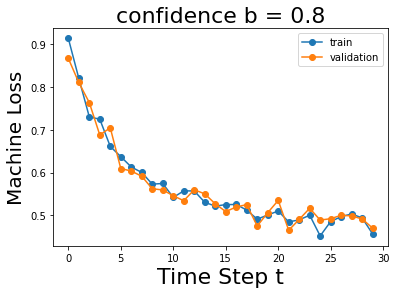

In [265]:
for constraint in constraints:
    train_confidence(data_path,constraint)

In [111]:
def get_test_assignments_confidence(data_path,constraints):
    machine_type = 'confidence'
    loss_func = torch.nn.NLLLoss(reduction='none')
    data = load_data(data_path)
    test_X = torch.from_numpy(data['test']['X']).float().to(device)
    test_Y = data['test']['Y']
    hlabel = data['test']['hpred']
    hconf = (torch.mean(data['hprob']) + torch.zeros(test_X.shape[0])).to(device)
    
    losses = []
    for constraint in constraints:
        mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

        mnet.load_state_dict(torch.load(model_dir + 'm_' + machine_type + str(constraint)))
        mnet.eval()
        mlabel = torch.argmax(mnet(test_X),dim=1).cpu().data.numpy()
        loss = np.zeros(test_X.shape[0])
        mconf,_ = torch.max(mnet(test_X),axis = 1)
        to_machine = find_machine_samples(hconf,mconf,constraint).cpu().data.numpy()

        to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])

        mloss = np.not_equal(mlabel,test_Y)
        hloss = np.not_equal(hlabel,test_Y)

        loss[to_machine] = mloss[to_machine]
        loss[to_human] =  hloss[to_human]

        losses.append(np.mean(loss))
        del mnet
        
    plt.plot(constraints,losses,marker='o')
    plt.title(r'Confidence-based Triage',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.show()
    
    if machine_type not in data.keys():
        data[machine_type] = {}
        
    data[machine_type]['agg_loss'] = losses
    
    save_data(data,data_path)

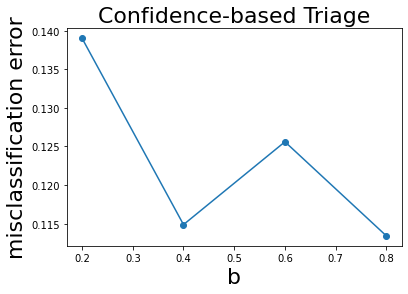

In [112]:
get_test_assignments_confidence(data_path,constraints)

## Full Automation Triage
The machine model is trained under full automation and then an additional model g is trained based on the difference of machine and human loss and used to outsource samples at test time.

In [27]:
def train_full(data_path, machine_type):
    print('-----training machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).long().to(device)
    hloss = data['hloss'].to(device)
    hconf = torch.mean(data['hprob']) + torch.zeros(X.shape[0]).to(device)
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hloss = data['val']['hloss'].to(device)
    val_hconf = torch.mean(data['hprob']) + torch.zeros(val_X.shape[0]).to(device)
    
    batch_size = 64
    num_batches = int(X.shape[0] / batch_size)
    val_num_batches = int(val_X.shape[0]/batch_size)
    
    num_epochs = 30
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    optimizer = torch.optim.Adam(mnet.parameters(),lr=0.0002)
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            optimizer.zero_grad()
            loss = loss_func(mnet(X_batch),Y_batch)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        with torch.no_grad():
            val_loss = float(loss_func(mnet(val_X),val_Y).mean())
            print('val_loss:',val_loss)
            val_losses.append(val_loss)
            if val_loss + eps < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_' + machine_type)
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
                
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break

        print('\n')
    
    
    plt.plot(range(len(train_losses)),train_losses,marker='o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker='o',label = 'validation')
    plt.legend()
    plt.title(machine_type, fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()
        

-----training machine model:  full
----- epoch: 0 -----
machine_loss: 0.7969858228849868
val_loss: 0.724065363407135
updated the model


----- epoch: 1 -----
machine_loss: 0.7350785274369022
val_loss: 0.6978760957717896
updated the model


----- epoch: 2 -----
machine_loss: 0.7031765538267791
val_loss: 0.6645820736885071
updated the model


----- epoch: 3 -----
machine_loss: 0.6835476720395187
val_loss: 0.6541575193405151
updated the model


----- epoch: 4 -----
machine_loss: 0.6654547685757279
val_loss: 0.6386374831199646
updated the model


----- epoch: 5 -----
machine_loss: 0.6589919719845057
val_loss: 0.6279982924461365
updated the model


----- epoch: 6 -----
machine_loss: 0.6529423833514253
val_loss: 0.6196128726005554
updated the model


----- epoch: 7 -----
machine_loss: 0.6484696667951843
val_loss: 0.6239945292472839


----- epoch: 8 -----
machine_loss: 0.6406546607613564
val_loss: 0.6075472235679626
updated the model


----- epoch: 9 -----
machine_loss: 0.6376717506597439
val

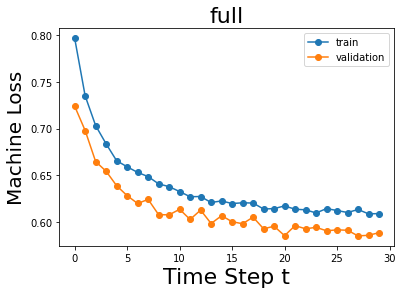

In [28]:
train_full(data_path,'full')

started training g using the constraint:  0.2  Using machine model:  full
----- epoch: 0 -----
g_loss: 0.5598234731393555
val_g_loss: 0.5240846276283264
updated the model


----- epoch: 1 -----
g_loss: 0.5046144087488452
val_g_loss: 0.5132489204406738
updated the model


----- epoch: 2 -----
g_loss: 0.49610185514514643
val_g_loss: 0.49782660603523254
updated the model


----- epoch: 3 -----
g_loss: 0.5000655421366295
val_g_loss: 0.49493980407714844
updated the model


----- epoch: 4 -----
g_loss: 0.4874679126466314
val_g_loss: 0.5185264945030212


----- epoch: 5 -----
g_loss: 0.484430151215444
val_g_loss: 0.4829380214214325
updated the model


----- epoch: 6 -----
g_loss: 0.48026104799161357
val_g_loss: 0.4845322370529175


----- epoch: 7 -----
g_loss: 0.4813017804796497
val_g_loss: 0.5098101496696472


----- epoch: 8 -----
g_loss: 0.47994931957994896
val_g_loss: 0.4964989423751831


----- epoch: 9 -----
g_loss: 0.47194284992292523
val_g_loss: 0.48387300968170166


----- epoch: 10 ----

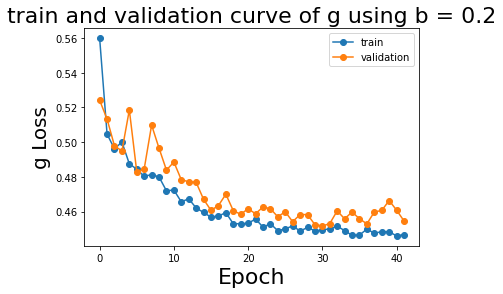

started training g using the constraint:  0.4  Using machine model:  full
----- epoch: 0 -----
g_loss: 0.694801225947837
val_g_loss: 0.6421099901199341
updated the model


----- epoch: 1 -----
g_loss: 0.6273076470630864
val_g_loss: 0.5999236106872559
updated the model


----- epoch: 2 -----
g_loss: 0.6044414189333717
val_g_loss: 0.5961282849311829
updated the model


----- epoch: 3 -----
g_loss: 0.6039853546147546
val_g_loss: 0.5803484916687012
updated the model


----- epoch: 4 -----
g_loss: 0.5873152506537735
val_g_loss: 0.5803451538085938


----- epoch: 5 -----
g_loss: 0.5768893741381665
val_g_loss: 0.5973979234695435


----- epoch: 6 -----
g_loss: 0.582002147876968
val_g_loss: 0.6378083825111389


----- epoch: 7 -----
g_loss: 0.5691128500426809
val_g_loss: 0.5982528924942017


----- epoch: 8 -----
g_loss: 0.5682044161173204
val_g_loss: 0.5537775158882141
updated the model


----- epoch: 9 -----
g_loss: 0.5604082636224726
val_g_loss: 0.5565330386161804


----- epoch: 10 -----
g_loss

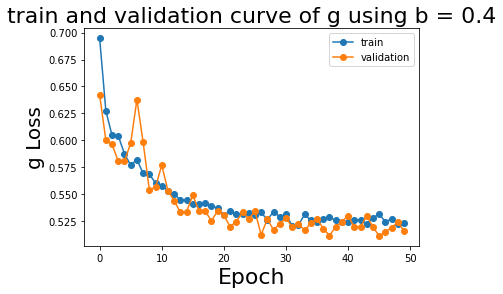

started training g using the constraint:  0.6  Using machine model:  full
----- epoch: 0 -----
g_loss: 0.690172467691203
val_g_loss: 0.6373202800750732
updated the model


----- epoch: 1 -----
g_loss: 0.6308054827774564
val_g_loss: 0.6060316562652588
updated the model


----- epoch: 2 -----
g_loss: 0.6205246845881144
val_g_loss: 0.7262874245643616


----- epoch: 3 -----
g_loss: 0.6073324602718154
val_g_loss: 0.5993195176124573
updated the model


----- epoch: 4 -----
g_loss: 0.5995092232090732
val_g_loss: 0.621848464012146


----- epoch: 5 -----
g_loss: 0.5953772133216262
val_g_loss: 0.6248786449432373


----- epoch: 6 -----
g_loss: 0.5932805682532489
val_g_loss: 0.6312996745109558


----- epoch: 7 -----
g_loss: 0.5821544594752291
val_g_loss: 0.5945559144020081
updated the model


----- epoch: 8 -----
g_loss: 0.5796239874325693
val_g_loss: 0.6025280952453613


----- epoch: 9 -----
g_loss: 0.5814169187409183
val_g_loss: 0.5680861473083496
updated the model


----- epoch: 10 -----
g_loss

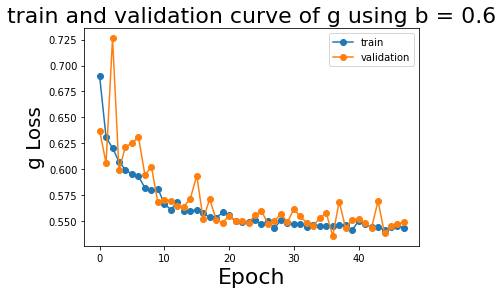

started training g using the constraint:  0.8  Using machine model:  full
----- epoch: 0 -----
g_loss: 0.6258119284175336
val_g_loss: 0.5771389007568359
updated the model


----- epoch: 1 -----
g_loss: 0.5839182175695896
val_g_loss: 0.5624814033508301
updated the model


----- epoch: 2 -----
g_loss: 0.5675768749788404
val_g_loss: 0.5726041793823242


----- epoch: 3 -----
g_loss: 0.5539186100165049
val_g_loss: 0.5679513812065125


----- epoch: 4 -----
g_loss: 0.5429931200730304
val_g_loss: 0.5560473203659058
updated the model


----- epoch: 5 -----
g_loss: 0.5421524670285484
val_g_loss: 0.5925610065460205


----- epoch: 6 -----
g_loss: 0.5429636860887209
val_g_loss: 0.5484476089477539
updated the model


----- epoch: 7 -----
g_loss: 0.5431734891608357
val_g_loss: 0.5464231371879578
updated the model


----- epoch: 8 -----
g_loss: 0.5381665633370479
val_g_loss: 0.5427263379096985
updated the model


----- epoch: 9 -----
g_loss: 0.5333529350658258
val_g_loss: 0.5340934991836548
updated th

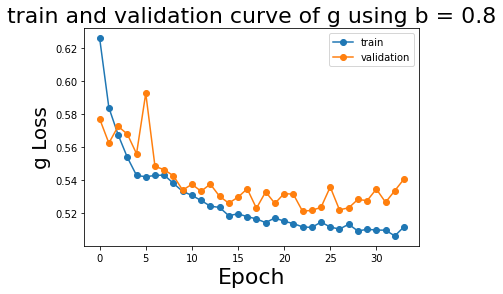

In [115]:
for constraint in constraints:
    train_g(data_path,'full',constraint)

In [116]:
def get_test_assignments_full(data_path,constraints):
    machine_type = 'full'
    loss_func = torch.nn.NLLLoss(reduction='none')
    data = load_data(data_path)
    test_X = torch.from_numpy(data['test']['X']).float().to(device)
    test_Y = data['test']['Y']
    hlabel = data['test']['hpred']
    
    mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    mnet.load_state_dict(torch.load(model_dir + 'm_full'))
    mnet.eval()
    mlabel = torch.argmax(mnet(test_X),dim=1).cpu().data.numpy()
    
    losses = []
    for constraint in constraints:
        loss = np.zeros(test_X.shape[0])
        num_machine = int((1.0 - constraint) * test_X.shape[0])
    
        gnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=2, dropout=0.5).to(device)

        gnet.load_state_dict(torch.load(model_dir + 'g_full' + str(constraint)))
        gnet.eval()
        gprediction = torch.exp(gnet(test_X).detach()[:,1])
        to_machine = torch.argsort(gprediction)[:num_machine].cpu().data.numpy()
        to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])
        
        mloss = np.not_equal(mlabel,test_Y)
        hloss = np.not_equal(hlabel,test_Y)

        loss[to_machine] = mloss[to_machine]
        loss[to_human] =  hloss[to_human]

        losses.append(np.mean(loss))
        
    plt.plot(constraints,losses,marker='o')
    plt.title(r'Full Automaion Triage',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.show()
    
    if machine_type not in data:
        data[machine_type] = {}
        
    data[machine_type]['agg_loss'] = losses
    save_data(data,data_path)

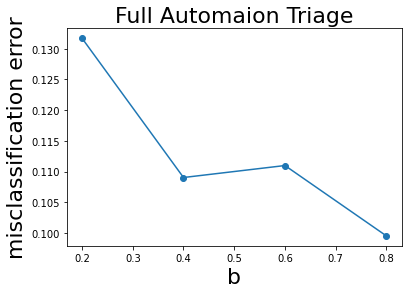

In [117]:
get_test_assignments_full(data_path,constraints)

## [Score-based Triage](https://arxiv.org/abs/1903.12220)

-----training machine model:  score
----- epoch: 0 -----
machine_loss: 0.8074621151511868
val_loss: 0.7436777949333191
updated the model


----- epoch: 1 -----
machine_loss: 0.7136768684722483
val_loss: 0.7006784081459045
updated the model


----- epoch: 2 -----
machine_loss: 0.6705588353797793
val_loss: 0.6683188676834106
updated the model


----- epoch: 3 -----
machine_loss: 0.6518366993404925
val_loss: 0.640255331993103
updated the model


----- epoch: 4 -----
machine_loss: 0.6358686801977456
val_loss: 0.6346648931503296
updated the model


----- epoch: 5 -----
machine_loss: 0.6220886722827951
val_loss: 0.621097207069397
updated the model


----- epoch: 6 -----
machine_loss: 0.6174987203752001
val_loss: 0.6104094982147217
updated the model


----- epoch: 7 -----
machine_loss: 0.6108652814291418
val_loss: 0.6032730937004089
updated the model


----- epoch: 8 -----
machine_loss: 0.6058215748829147
val_loss: 0.6013314723968506
updated the model


----- epoch: 9 -----
machine_loss: 0.60

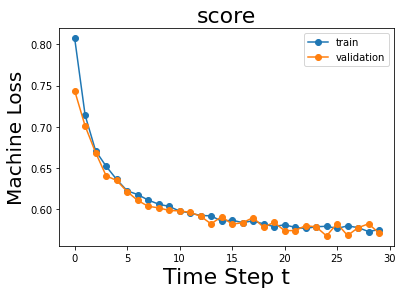

In [268]:
train_full(data_path,'score')

In [269]:
def get_assignments_score(data_path,constraints):
    machine_type = 'score'
    loss_func = torch.nn.NLLLoss(reduction='none')
    data = load_data(data_path)
    test_X = torch.from_numpy(data['test']['X']).float().to(device)
    test_Y = data['test']['Y']
    hlabel = data['test']['hpred']
    
    mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    mnet.load_state_dict(torch.load(model_dir + 'm_score'))
    mnet.eval()
    mlabel = torch.argmax(mnet(test_X),dim=1).cpu().data.numpy()
    loss = np.zeros(test_X.shape[0])
    mconf,_ = torch.max(mnet(test_X),axis = 1)
    
    losses = []
    for constraint in constraints:
        num_machine = int((1.0-constraint) * test_X.shape[0])
        to_machine = torch.argsort(mconf,descending = True)[:num_machine].cpu().data.numpy()
        to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])

        mloss = np.not_equal(mlabel,test_Y)
        hloss = np.not_equal(hlabel,test_Y)

        loss[to_machine] = mloss[to_machine]
        loss[to_human] =  hloss[to_human]

        losses.append(np.mean(loss))
        
    plt.plot(constraints,losses,marker='o')
    plt.title(r'Score-based Triage',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.show()
    if machine_type not in data.keys():
        data[machine_type] = {}
        
    data[machine_type]['agg_loss'] = losses
    save_data(data,data_path)


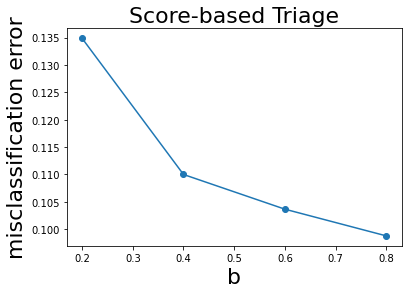

In [237]:
get_assignments_score(data_path,constraints)

## [Surrogate-based Triage](https://arxiv.org/abs/2006.01862)
The code is taken from [here](https://github.com/clinicalml/learn-to-defer) where the authors provide implementation of their method.

In [270]:
def surrogate_train(data_path):

    def loss_func(outputs, m, labels, m2, n_classes):
        '''
        The L_{CE} loss implementation for hatespeech, identical to CIFAR implementation
        ----
        outputs: network outputs
        m: cost of deferring to expert cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        labels: target
        m2:  cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes
        '''
        batch_size = outputs.shape[0] # batch_size
        rc = [n_classes] * batch_size

        rc = torch.tensor(rc)

        outputs = -m * torch.log2(outputs[range(batch_size), rc]) - m2 * torch.log2(outputs[range(batch_size), labels])  # pick the values corresponding to the labels
        return torch.sum(outputs)/batch_size
    
    print('-----training machine model : surrogate')
    machine_type = 'surrogate'
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).to(device).long()
    human_is_correct = torch.from_numpy(np.array([1 if data['hpred'][i]==data['Y'][i] else 0
                                                  for i in range(X.shape[0])])).to(device)
    alpha = 1.0
    m = (1 - human_is_correct) * 1.0
    m2 = [1.0] * X.shape[0]
    m2 = torch.tensor(m2)
    for j in range(0, X.shape[0]):
        exp = m[j].item()
        if exp:
            m2[j] = alpha
        else:
            m2[j] = 1
    m2 = m2.to(device)


    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).to(device).long()
    val_human_is_correct = torch.from_numpy(np.array([1 if data['val']['hpred'][i] == data['val']['Y'][i] else 0
                                                      for i in range(val_X.shape[0])])).to(device)
    val_m = (1 - val_human_is_correct) * 1.0
    val_m2 = [1.0] * val_X.shape[0]
    val_m2 = torch.tensor(val_m2)
    for j in range(0, val_X.shape[0]):
        exp = val_m[j].item()
        if exp:
            val_m2[j] = alpha
        else:
            val_m2[j] = 1
    val_m2 = val_m2.to(device)
    
    batch_size = 64
    num_epochs = 30

    num_batches = int(X.shape[0] / batch_size)
    
    N_FILTERS = 300  # hyperparameterr
    FILTER_SIZES = [3, 4, 5]
    DROPOUT = 0.5
    output_dim = 3
    mnet = CNN_rej(embedding_dim = 100,vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)
    optimizer = torch.optim.Adam(mnet.parameters(),lr=0.005)
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4

    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        epoch_loss = 0
        val_epoch_loss = 0
        for i in range(num_batches):
            X_batch = X[i * batch_size:(i + 1) * batch_size]
            Y_batch = Y[i * batch_size:(i + 1) * batch_size]
            m_batch = m[i * batch_size:(i + 1) * batch_size]
            m2_batch = m2[i * batch_size:(i + 1) * batch_size]

            optimizer.zero_grad()
            loss = loss_func(mnet(X_batch),m_batch,Y_batch,m2_batch,output_dim)
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss)


        print('train loss: ',epoch_loss/ num_batches)
        train_losses.append(epoch_loss / num_batches)
        with torch.no_grad():
            m_val_prob = mnet(val_X)
            val_loss = loss_func(m_val_prob, val_m, val_Y, val_m2, output_dim)
            val_losses.append(float(val_loss))
            print('validation loss: ', float(val_loss))
            
            if val_loss < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_surrogate')
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            
            if patience > max_patience:
                print('no progress for 10 epochs... stopping training')
                break
    
        print('\n')
            
    plt.plot(range(len(train_losses)),train_losses,marker='o',label = 'train')
    plt.plot(range(len(val_losses)),val_losses,marker='o', label = 'validation')
    plt.legend()
    plt.title(machine_type,fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.legend()
    plt.show()

-----training machine model : surrogate
----- epoch: 0 -----
train loss:  1.7675775239864986
validation loss:  1.4769911766052246
updated the model


----- epoch: 1 -----
train loss:  1.4780045424898465
validation loss:  1.4151028394699097
updated the model


----- epoch: 2 -----
train loss:  1.3914768447478612
validation loss:  1.3882659673690796
updated the model


----- epoch: 3 -----
train loss:  1.3414464521532257
validation loss:  1.313531756401062
updated the model


----- epoch: 4 -----
train loss:  1.315017854484419
validation loss:  1.3374478816986084


----- epoch: 5 -----
train loss:  1.311991850535075
validation loss:  1.3379569053649902


----- epoch: 6 -----
train loss:  1.3051490833361943
validation loss:  1.3305485248565674


----- epoch: 7 -----
train loss:  1.3008162633826335
validation loss:  1.3130309581756592
updated the model


----- epoch: 8 -----
train loss:  1.2967546069994569
validation loss:  1.313415765762329


----- epoch: 9 -----
train loss:  1.2947272785

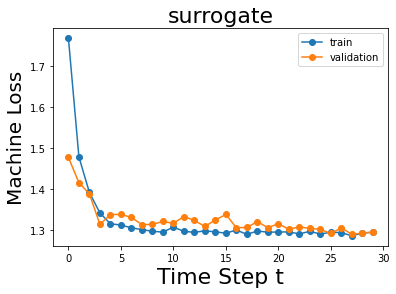

In [271]:
surrogate_train(data_path)

In [219]:
def get_test_assignments_surrogate(data_path,constraints):
    machine_type = 'surrogate'
    loss_func = torch.nn.NLLLoss(reduction='none')
    data = load_data(data_path)
    test_X = torch.from_numpy(data['test']['X']).float().to(device)
    test_Y = data['test']['Y']
    hlabel = data['test']['hpred']
    
    mnet = CNN_rej(embedding_dim=100,vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    mnet.load_state_dict(torch.load(model_dir + 'm_surrogate'))
    mnet.eval()
    mscores = mnet(test_X)
    assert(mscores.shape[1]==4)
    mlabel = torch.argmax(mscores[:,:-1],dim=1).cpu().data.numpy()
    assert (mlabel<4).all()
    loss = np.zeros(test_X.shape[0])
    last_class_prob = mscores[:,-1]
    highest_prob,_ = torch.max(mscores[:,:-1],dim=1)
    diff = last_class_prob - highest_prob
    
    losses = []
    for constraint in constraints:
        num_machine = int((1.0-constraint) * test_X.shape[0])
        to_machine = torch.argsort(diff)[:num_machine].cpu().data.numpy()
        to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])

        mloss = np.not_equal(mlabel,test_Y)
        hloss = np.not_equal(hlabel,test_Y)

        loss[to_machine] = mloss[to_machine]
        loss[to_human] =  hloss[to_human]

        losses.append(np.mean(loss))
        
    plt.plot(constraints,losses,marker='o')
    plt.title(r'Surrogate-based Triage',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    
    if machine_type not in data.keys():
        data[machine_type] = {}

    data[machine_type]['agg_loss'] = losses
    save_data(data,data_path)


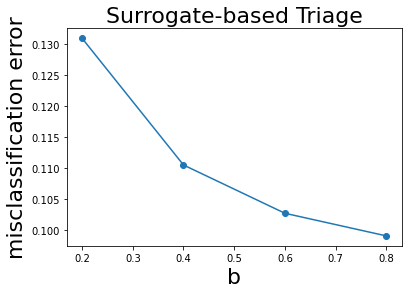

In [220]:
get_test_assignments_surrogate(data_path,constraints)

In [221]:
def plot_misclassification_loss(data_path,machine_types):
    data = load_data(data_path)
    for machine_type in machine_types:
        agg_loss = data[machine_type]['agg_loss']
        plt.plot(constraints,agg_loss,marker='o',label=machine_type)
    plt.xticks(constraints)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.legend()

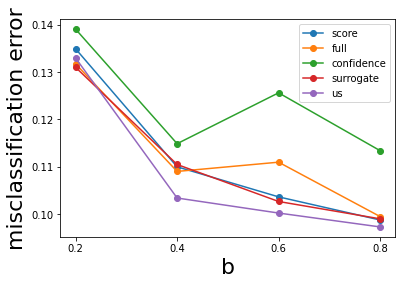

In [255]:
machine_types =  ['score','full','confidence','surrogate','Differentiable']
plot_misclassification_loss(data_path,machine_types)